Så det er vel et empirisk spørgsmål om (0,0) skal væk. Men i rapporten tror jeg det gav meget bedre resultater. MEN hvis du fjerner dem ka ndu ikke mere sammenligne billeder på tværs af kodere....

- Tjek forskel på hvor mange (0,0)' er hver kodere har
- Tjek forskel på om du beholder (0,0) eller ej ift. meningsfulde resultater.
- Tjek om du bliver nød til
- Du har tre forskellige mål. Du skal se hvilke der giver mest meningsfulde resultater
- Test om en ensample er bedere og hvor meget de tre resultater corrolere.

**so now**:
Make a for loop going over all features for all coders (right now just 1 and 3) and save this jazz in some nice format.

In [1]:
# can run from base

import os
import pickle

# from functions import * # import util functions
from collections import Counter
import numpy as np
import pandas as pd

import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

import choix

from IPython.display import clear_output

In [2]:
def get_df(att_dict = 1):
    """att_dict should be 1,2,3"""

    path = "/home/simon/Documents/Bodies/data/RA/att_dicts"

    file_name1 = "pregenerated_indx_list.pkl"
    file_path = os.path.join(path, file_name1)

    # Open the file in binary mode
    with open(file_path, 'rb') as file:
        
        # Call load method to deserialze
        pregenerated_indx_list = pickle.load(file)

    file_name2 = f"att_dict_{att_dict}.pkl"
    file_path = os.path.join(path, file_name2)

    if os.path.exists(file_path):

        # Open the file in binary mode
        with open(file_path, 'rb') as file:
        
            # Call load method to deserialze
            att_dict = pickle.load(file)

        df_img = pd.DataFrame(pregenerated_indx_list, columns=['img1', 'img2'])
        df_att = pd.DataFrame(att_dict, columns= att_dict.keys())
        df_att.drop(['indx_indicator'], axis=1, inplace= True)
        df = df_att.join(df_img)

        columns_dict= { 'att0' : 'negative_emotions_t1', 'att1': 'negative_emotions_t2', 'att2': 'mass_protest', 
                        'att3': 'damaged_property', 'att4': 'privat', 'att5': 'public', 
                        'att6': 'militarized', 'att7': 'rural', 'att8': 'urban', 'att9': 'formal' }

        df.rename(columns= columns_dict, inplace= True)

    else: 
        print('That att_dict does not exist. Use 1, 2, or 3.')

    return(df)



In [3]:
def print_zero_ratio(df):

    print("Ratio of (0,0)'s in each feature:\n")

    for i in df.columns[:-2]:
        ratio = (df[i] == (0,0)).sum() / df.shape[0]
        print(f'{i}: {ratio*100:.3}%')

    print('\n')


In [4]:
def analyse_network(G, plot = True):

    print(f'Number of edges: {len(G.edges)}') # same as len(indx_list)
    print(f'Number of nodes: {len(G.nodes)}') # same as len(indx_list)
    print(f'Connected network: {nx.is_connected(G)}')

    G_degrees = list(dict(G.degree).values())

    print(f'Mean degrees: {np.mean(G_degrees)}')
    print(f'Min degrees: {np.min(G_degrees)}')
    print(f'Max degrees: {np.max(G_degrees)}')

    clear_output(wait=True)

    if plot == True:

        plt.figure(figsize=[20,5])

        plt.subplot(1,3,1)
        plt.title('network random layout')
        nx.draw(G, pos=nx.random_layout(G), node_size = 50, node_color = 'blue', alpha = 0.2, width = 0.5, edge_color = 'black')

        plt.subplot(1,3,2)
        plt.title('network spring layout')
        nx.draw(G, pos=nx.spring_layout(G), node_size = 50, node_color = 'blue', alpha = 0.2, width = 0.5, edge_color = 'black')

        plt.subplot(1,3,3)
        plt.title('network degree distribution')
        plt.hist(G_degrees, density=True, bins= 50)
        sns.kdeplot(G_degrees)

        plt.show()

In [5]:
def get_non_draw_connected_sub_df(df, att):

    # remove draws
    non_draw_sub = df[(df[att] != (0,0)) & (df[att] != (1,1))][[att, 'img1', 'img2']]

    # get edge list from non-draw subset
    edge_list_non_zero = list(zip(non_draw_sub['img1'], non_draw_sub['img2']))

    # Full graph g
    g = nx.Graph()
    g.add_edges_from(edge_list_non_zero)

    # Get larges connected subset:
    connected_img = sorted(nx.connected_components(g), key = len, reverse=True)[0] # take the larges connected component - really the list you need.

    edge_list_connected = [(node1, node2) for node1, node2 in edge_list_non_zero if node1 in connected_img or node2 in connected_img]


    # Larges connected subgraph gc - just to check
    gc = nx.Graph()
    gc.add_edges_from(edge_list_connected)
    analyse_network(gc, False)
    

    # sub df

    non_draw_connected_sub_df = non_draw_sub[(non_draw_sub['img1'].isin(connected_img)) | (non_draw_sub['img2'].isin(connected_img))]

    return(non_draw_connected_sub_df) 

#edge_list_non_zero = list(zip(att_sub_df['img1'], att_sub_df['img2']))


In [6]:
def get_input_data(df, att):

    non_draw_connected_sub_df = get_non_draw_connected_sub_df(df, att)

    img_list = list(set(list(non_draw_connected_sub_df['img1']) +  list(non_draw_connected_sub_df['img2'])))
    n_imgs = len(img_list)
    img_idx_generator = img_list.index

    data = []

    for i in range(non_draw_connected_sub_df.shape[0]):

        img1_name = non_draw_connected_sub_df['img1'].iloc[i]
        img2_name = non_draw_connected_sub_df['img2'].iloc[i]

        img1_idx = img_idx_generator(img1_name)
        img2_idx = img_idx_generator(img2_name)

        
        if non_draw_connected_sub_df[att].iloc[i][0] > non_draw_connected_sub_df[att].iloc[i][1]:
            directed_edge = (img1_idx, img2_idx)
            data.append(directed_edge)

        elif non_draw_connected_sub_df[att].iloc[i][0] < non_draw_connected_sub_df[att].iloc[i][1]:
            directed_edge = (img2_idx, img1_idx)
            data.append(directed_edge)

        else: 
            print(f'something wrong w/ edge')
            pass

    return(data, n_imgs, img_list)

In [7]:
def get_att_data_dict(df):

    att_data_dict = {}

    for att in df.columns[:-2]:

        print(att)
        
        data, n_imgs, img_list = get_input_data(df, att)

        att_data_dict[f'{att}_data'] = data
        att_data_dict[f'{att}_n'] = n_imgs
        att_data_dict[f'{att}_img_list'] = img_list


    return(att_data_dict)

In [8]:
def get_results(df):

    att_data_dict = get_att_data_dict(df1)
    clear_output(wait=True)
    
    dict_of_dfs = {}

    for att in df.columns[:-2]:

        data = att_data_dict[f'{att}_data']
        n_imgs = att_data_dict[f'{att}_n']

        lsr_mean = choix.ilsr_pairwise(n_imgs, data, alpha=0.01) # 10-20 sec
        print(f'{att} lsr done')
        mm_mean = choix.mm_pairwise(n_imgs, data, alpha=0.05) # 2 ish min, needs a bit more reg/aalpha to converge
        print(f'{att} mm done')
        # eb_mean, eb_cov = choix.ep_pairwise(n_imgs, data, alpha=0.01, model = 'logit') # 20 ish min

        #result_dict = {'lsr_mean' : lsr_mean,'img' : att_data_dict[f'{att}_img_list']}

        result_dict = {'lsr_mean' : lsr_mean, 'mm_mean' : mm_mean , 'img' : att_data_dict[f'{att}_img_list']}
        results_df = pd.DataFrame(result_dict)

        dict_of_dfs[att] = results_df

    return(dict_of_dfs)

In [9]:
df1 = get_df(1)
print_zero_ratio(df1)
dict_of_dfs1 = get_results(df1)

negative_emotions_t1 lsr done
negative_emotions_t1 mm done
negative_emotions_t2 lsr done
negative_emotions_t2 mm done
mass_protest lsr done
mass_protest mm done
damaged_property lsr done
damaged_property mm done
privat lsr done
privat mm done
public lsr done
public mm done
militarized lsr done
militarized mm done
rural lsr done
rural mm done
urban lsr done
urban mm done
formal lsr done
formal mm done


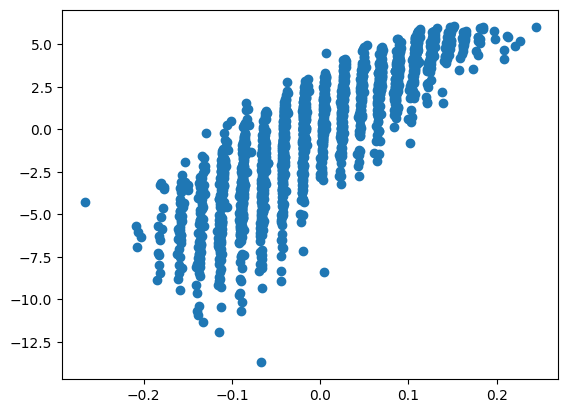

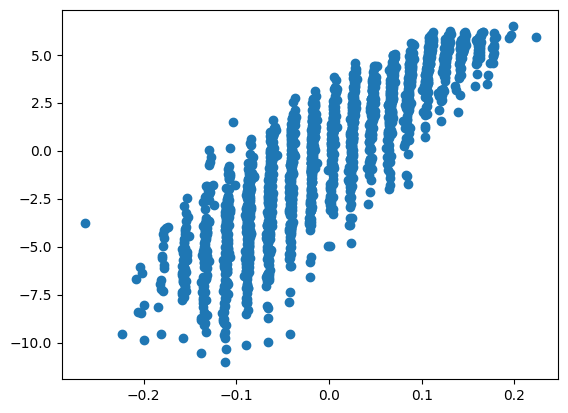

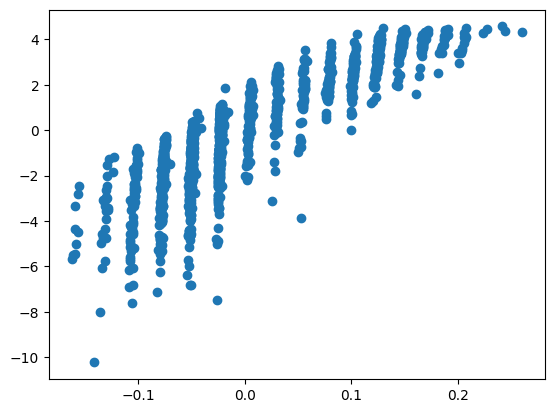

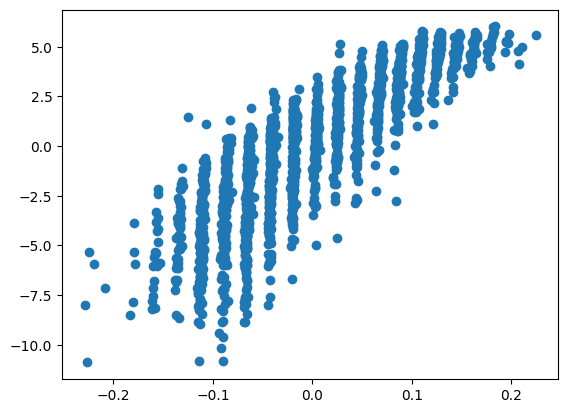

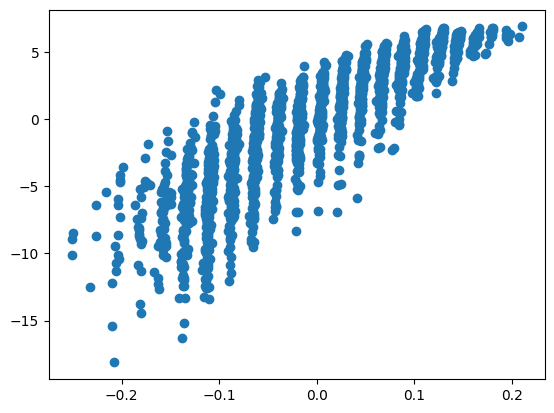

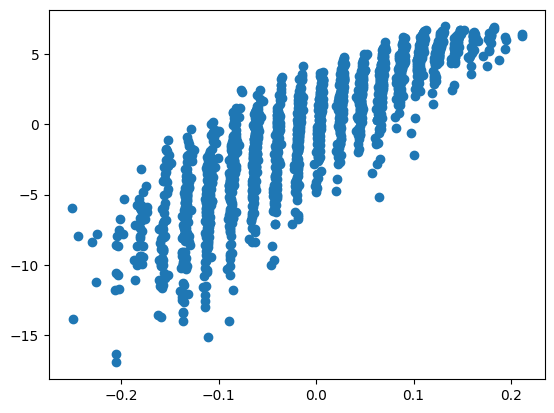

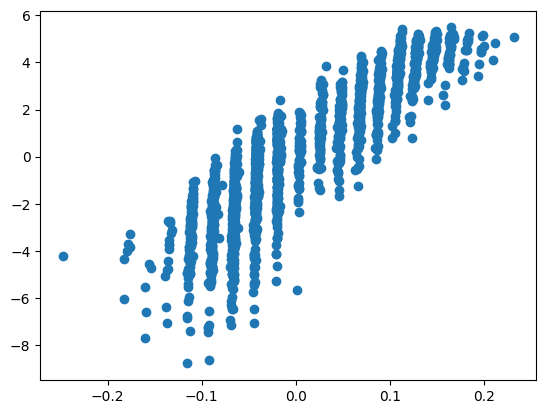

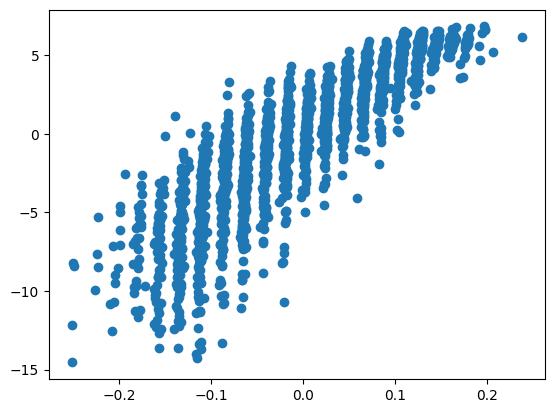

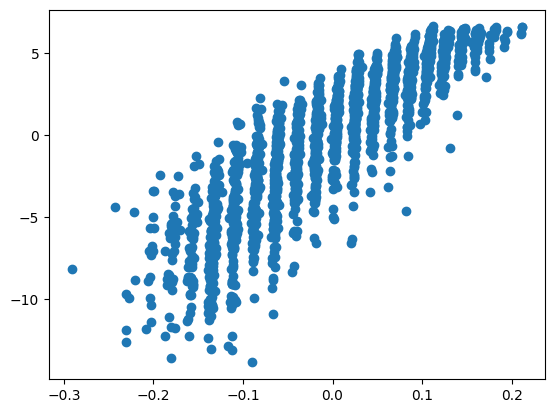

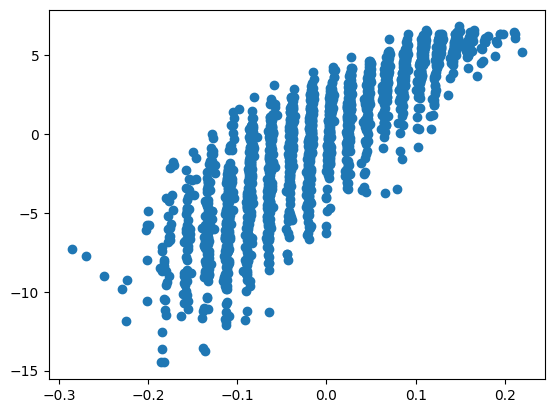

In [10]:
for key in dict_of_dfs1.keys():
    
    x = dict_of_dfs1[key]['lsr_mean']
    y = dict_of_dfs1[key]['mm_mean']
    plt.scatter(x,y)
    plt.show()
    

In [11]:
df3 = get_df(3)
print_zero_ratio(df3)
dict_of_dfs3 = get_results(df3)

negative_emotions_t1 lsr done
negative_emotions_t1 mm done
negative_emotions_t2 lsr done
negative_emotions_t2 mm done
mass_protest lsr done
mass_protest mm done
damaged_property lsr done
damaged_property mm done
privat lsr done
privat mm done
public lsr done
public mm done
militarized lsr done
militarized mm done
rural lsr done
rural mm done
urban lsr done
urban mm done
formal lsr done
formal mm done


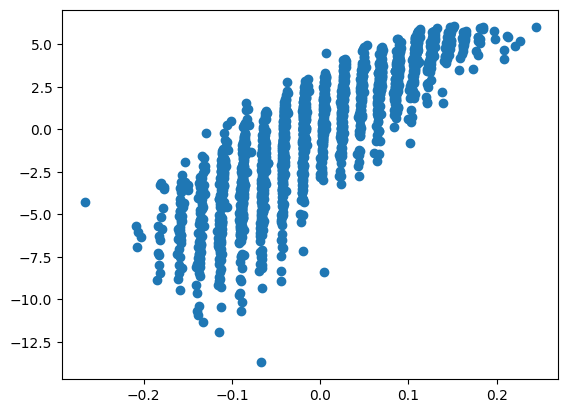

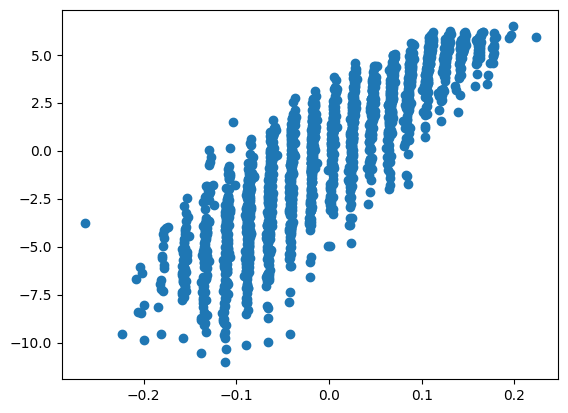

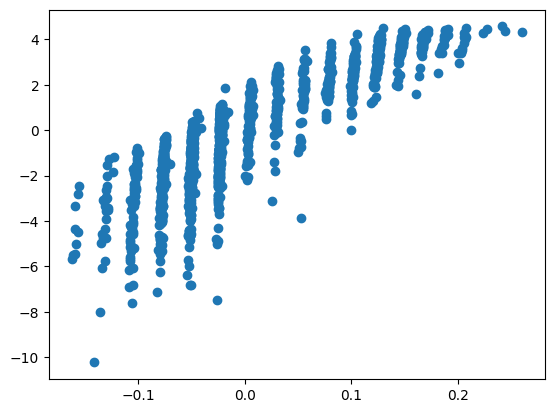

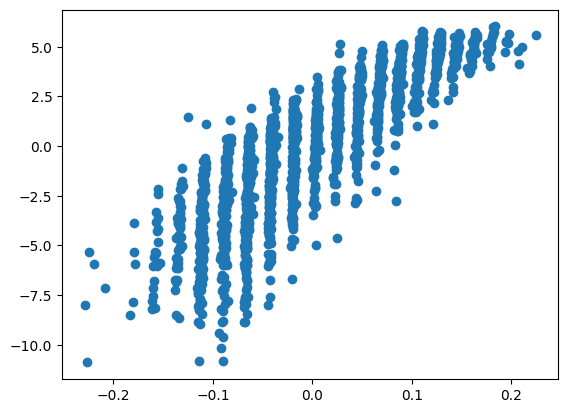

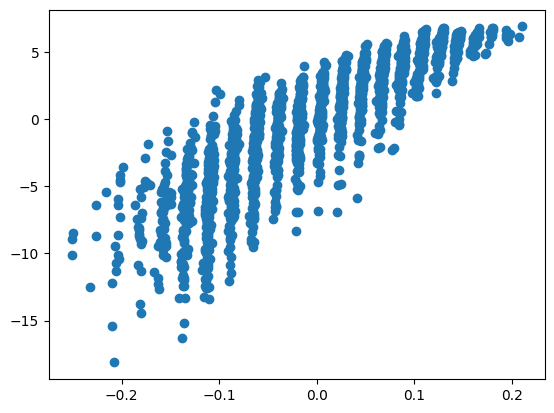

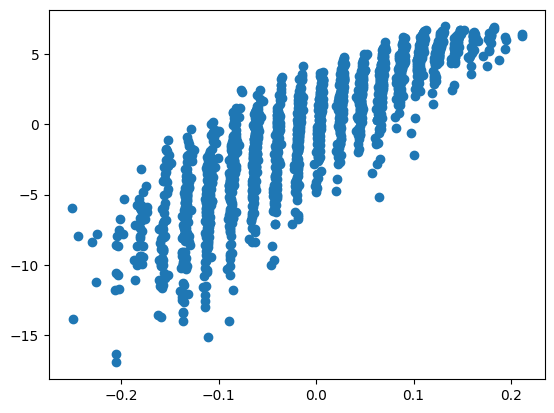

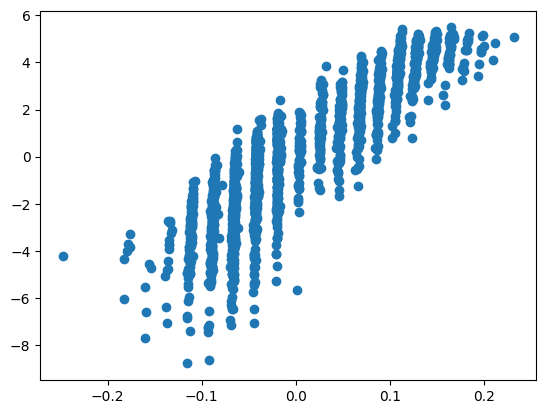

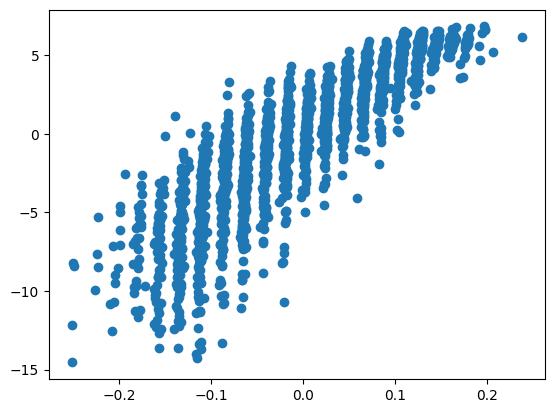

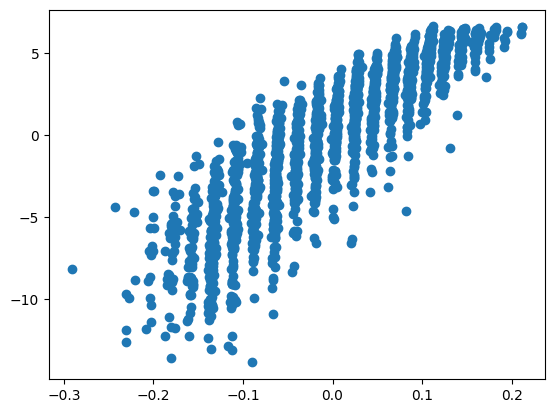

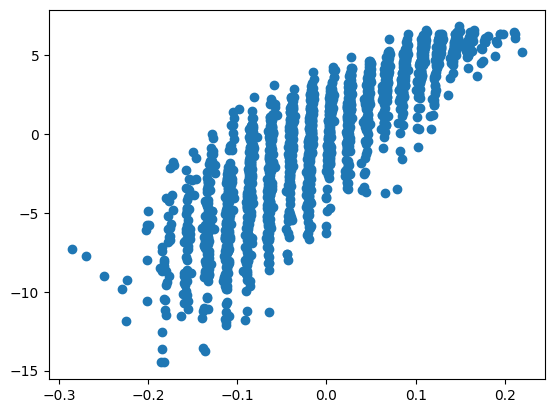

In [12]:
for key in dict_of_dfs3.keys():
    
    x = dict_of_dfs3[key]['lsr_mean']
    y = dict_of_dfs3[key]['mm_mean']
    plt.scatter(x,y)
    plt.show()